In [2]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryAccuracy

In [3]:
# Define device for torch
device = torch.device("cpu")
# MPS for Apple Silicon GPUs
if torch.mps.is_available():
   print("MPS is available")
   device = torch.device("mps")

# CUDA for Nvidia GPUs
if torch.cuda.is_available():
   print("CUDA is available")
   device = torch.device("cuda")
print(device)

MPS is available
mps


## Create a Script to conduct further data cleaning for NN

In [149]:
from sklearn.preprocessing import StandardScaler
import joblib

def feature_engineer(df):
   """Drops the 'date' column from the given dataframe."""
   if 'date' in df.columns:
      df = df.drop(columns=['date'])
   # lease flags
   df["is_lease_above_70"] = (df["lease_months_left"] > 840).astype(int)
   df["is_lease_below_50"] = (df["lease_months_left"] < 600).astype(int) 
   # storey flags
   df["high_storey"] = (df["storey_range"] > 0.7).astype(int)
   df["low_storey"] = (df["storey_range"] < 0.3).astype(int)
   # ratio
   df["asset_to_liability_ratio"] = df["assets"] / (df["liabilities"] + 1)

   return df
   

train_df = feature_engineer(pd.read_csv("data/train_data_w_macro.csv"))
test_df = feature_engineer(pd.read_csv("data/test_data_w_macro.csv"))
valid_df = feature_engineer(pd.read_csv("data/valid_data_w_macro.csv"))

to_normalize = [
    "lease_months_left", 
    "gdp in chained (2015) dollars", 
    "assets", 
    "liabilities", 
    "mas core inflation measure"
]
# Feature normalization
feature_scaler = StandardScaler()
train_df[to_normalize] = feature_scaler.fit_transform(train_df[to_normalize])
valid_df[to_normalize] = feature_scaler.transform(valid_df[to_normalize])
test_df[to_normalize] = feature_scaler.transform(test_df[to_normalize])

# Target normalization
target_scaler = StandardScaler()
train_df["resale_price"] = target_scaler.fit_transform(train_df[["resale_price"]])
valid_df["resale_price"] = target_scaler.transform(valid_df[["resale_price"]])
test_df["resale_price"] = target_scaler.transform(test_df[["resale_price"]])

# Store scalers for later
joblib.dump(feature_scaler, "scalers/feature_scaler.pkl")
joblib.dump(target_scaler, "scalers/target_scaler.pkl")


['scalers/target_scaler.pkl']

In [132]:
train_df.info()
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print(train_df.shape)
print(test_df.shape)
print(valid_df.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157062 entries, 0 to 157061
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   storey_range                   157062 non-null  float64
 1   floor_area_sqm                 157062 non-null  float64
 2   lease_months_left              157062 non-null  float64
 3   resale_price                   157062 non-null  float64
 4   gdp in chained (2015) dollars  157062 non-null  float64
 5   assets                         157062 non-null  float64
 6   liabilities                    157062 non-null  float64
 7   mas core inflation measure     157062 non-null  float64
 8   m_from2017                     157062 non-null  float64
 9   town_tampines                  157062 non-null  int64  
 10  town_punggol                   157062 non-null  int64  
 11  town_sembawang                 157062 non-null  int64  
 12  town_choa chu kang            

In [133]:
display(train_df)

,storey_range,floor_area_sqm,lease_months_left,resale_price,gdp in chained (2015) dollars,assets,liabilities,mas core inflation measure,m_from2017,town_tampines,...,town_choa chu kang,town_sengkang,flat_model_Apartment,flat_model_DBSS,flat_model_Maisonette,is_lease_above_70,is_lease_below_50,high_storey,low_storey,asset_to_liability_ratio
0,0.0000,0.287736,1.443622,0.684373,0.522848,0.457859,0.829841,0.280707,0.684211,0,...,0,0,0,0,0,1,0,0,1,7.874546
1,0.0000,0.273585,-0.714364,-0.283156,1.394325,1.219070,1.005790,1.311822,0.852632,0,...,0,0,0,0,0,0,0,0,1,8.726054
2,0.5625,0.287736,1.348765,1.578145,1.722337,1.615420,1.689993,1.786185,0.957895,0,...,0,0,0,0,0,1,0,0,0,8.958084
3,0.2500,0.278302,0.749984,-0.946926,-0.756953,-1.112826,-0.403701,-0.779763,0.210526,0,...,0,0,0,0,0,1,0,0,1,6.298617
4,0.2500,0.075472,1.206480,-1.453191,-0.019800,0.115599,0.145449,-0.545516,0.568421,0,...,0,1,0,0,0,1,0,0,1,7.671115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157057,0.0625,0.264151,1.319123,2.248170,0.384571,0.376178,0.610203,-0.159215,0.631579,0,...,0,0,0,0,0,1,0,0,1,7.844492
157058,0.0625,0.160377,-1.550287,-1.284436,-0.019800,0.115599,0.145449,-0.498158,0.578947,0,...,0,0,0,0,0,0,0,0,1,7.671115
157059,0.1875,0.169811,1.153124,-0.159402,0.935297,0.665845,0.732957,0.780119,0.747368,0,...,0,0,0,0,0,1,0,0,1,8.154802
157060,0.3125,0.339623,-0.091868,0.476242,1.394325,1.219070,1.005790,1.474835,0.873684,0,...,0,0,0,0,0,1,0,0,0,8.726054


# Define our Dataset object and Dataloaders

In [134]:
class HDBDataset(Dataset):
    def __init__(self, dataframe):
        dataframe = dataframe.reset_index(drop=True)  # Important
        self.features = dataframe.drop(columns=dataframe.columns[3]).to_numpy(dtype=np.float32)
        self.targets = dataframe.iloc[:, 3].to_numpy(dtype=np.float32)
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        features = torch.from_numpy(self.features[idx])
        target = torch.tensor(self.targets[idx])
        return features, target


In [135]:
batch_size = 512

train_dataset = HDBDataset(train_df)
valid_dataset = HDBDataset(valid_df)
test_dataset = HDBDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle= False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle= False)

# Define our model

In [137]:
class HDBPricePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(21, 128)
        self.hidden1 = nn.Linear(128, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.fc = nn.Linear(32, 1)
        self.activation = nn.ReLU()
        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.input(x)
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.fc(x)
        return x

# Simple Neural Net Training

In [145]:
# New model to train

class HDBPricePredictor2(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(21, 512)
        self.hidden1 = nn.Linear(512, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.fc = nn.Linear(64, 1)

        # Activation functions
        self.activation = nn.LeakyReLU(0.01)  # More stable than ReLU

        # Normalization & Dropout
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(64)

        self.dropout = nn.Dropout(0.1)  # Light dropout

        # Use Huber Loss instead of MSE
        self.loss = nn.L1Loss()

        # Initialize weights
        self._init_weights()

    def forward(self, x):
        x = self.input(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.hidden1(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.hidden2(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.hidden3(x)
        x = self.bn4(x)
        x = self.activation(x)

        x = self.fc(x)
        return x

    def _init_weights(self):
        for layer in [self.input, self.hidden1, self.hidden2, self.hidden3, self.fc]:
            nn.init.kaiming_normal_(layer.weight, nonlinearity='leaky_relu')
            nn.init.constant_(layer.bias, 0)



In [ ]:
# Create Neural Network model
model = HDBPricePredictor2().to(device)

# Gradient descent parameters: optimizers, repetitions, etc.
num_epochs = 250
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=0.0005,
                           betas=(0.9, 0.999),
                           eps=1e-08,
                           weight_decay=0.001)
optimizer.zero_grad()

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    # Create lists for the epoch's train accuracies
    batch_train_losses = []
    batch_validation_losses = []
    for batch in train_loader:
        # Unpack the mini-batch data
        inputs_batch, outputs_batch = batch
        outputs_re = outputs_batch.to(device).reshape(-1, 1)
        inputs_re = inputs_batch.to(device)
        
        # Forward pass
        pred = model(inputs_re)
        loss_value = model.loss(pred.float(), outputs_re.float())
    
        # Backward pass and optimization
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        batch_train_losses.append(loss_value.item())
    train_losses.append(sum(batch_train_losses)/len(batch_train_losses))
    # Validation loop
    model.eval()
    
    print("Training done! Validation commencing...")
    with torch.no_grad():
        for batch in valid_loader:
            inputs_batch, outputs_batch = batch
            outputs_re = outputs_batch.to(device).reshape(-1, 1)
            inputs_re = inputs_batch.to(device)
            
            pred = model(inputs_re)
            val_loss = model.loss(pred.float(), outputs_re.float())
            
            batch_validation_losses.append(val_loss.item())
        val_losses.append(sum(batch_validation_losses)/len(batch_validation_losses))
    
    print(f'Epoch [{epoch+1}/{num_epochs}]', f'Train Loss: {loss_value.item():.4f}',f'Val Loss: {val_loss.item():.4f}')
    
    # Save the model weights for each epoch
    torch.save(model.state_dict(), f'nn_model1_weights/model2_weights_epoch_{epoch+1}.pth')

# Simple Neural Net Assessment

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.title('Train Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [141]:
print(train_losses)

[0.4056885460883088, 0.3453586765531608, 0.33638971713932797, 0.3304033743442076, 0.32680674630189954, 0.3256586653207723, 0.32354754966710986, 0.32262644356159126, 0.3210255143502636, 0.31910181550327266, 0.31737279086237236, 0.315645713468328, 0.3134219570734602, 0.3128737564583943, 0.3120442867667357, 0.3100357471149208, 0.3093733779770544, 0.309500723203541, 0.30795603068333105, 0.3068665233031158, 0.3065086541036053, 0.3067181524896466, 0.30512455474670236, 0.30514763611147383, 0.30453959447164874, 0.30399374027982207, 0.30328154631856985, 0.3030984648275841, 0.30268776397363373, 0.3028440215300271, 0.301470002250485, 0.30179364275466347, 0.30074076728246113, 0.3006481653510165, 0.30084018404398366, 0.3007391348529716, 0.3000056352405672, 0.30027349938787157, 0.2985325108619, 0.2994074445788169, 0.29898441779497004, 0.29882741488928904, 0.2988516115598647, 0.29774567533393637, 0.29791218639390865, 0.2981519470968153, 0.2971955412568021, 0.2975686267261008, 0.29736623391266365, 0.2

In [150]:
# 1. Reload your model architecture
model = HDBPricePredictor2().to(device)

# 2. Load the saved weights
model.load_state_dict(torch.load('nn_model1_weights/model2_weights_epoch_249.pth'))  # <-- no weights_only=True
model.eval()  # Important: set to evaluation mode

test_losses = []
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        inputs_batch, outputs_batch = batch
        outputs_re = outputs_batch.to(device).reshape(-1, 1)  # normalized resale prices
        inputs_re = inputs_batch.to(device)

        # 3. Forward pass
        test_pred = model(inputs_re)

        # 4. Compute loss (still in normalized space)
        loss = model.loss(test_pred.float(), outputs_re.float())
        test_losses.append(loss.item())

        # 5. Save preds and targets for later (to de-normalize and check real values)
        all_preds.append(test_pred.cpu())
        all_targets.append(outputs_re.cpu())

# 6. Calculate avg test loss (normalized)
avg_test_loss = sum(test_losses) / len(test_losses)
print(f'Test Loss (normalized): {avg_test_loss:.4f}')

# 7. De-normalize predictions and targets to get real SGD prices

# Load feature scaler
feature_scaler = joblib.load('scalers/feature_scaler.pkl')
# Load target scaler (for resale price)
target_scaler = joblib.load('scalers/target_scaler.pkl')

all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

all_preds_real = target_scaler.inverse_transform(all_preds)
all_targets_real = target_scaler.inverse_transform(all_targets)

# 8. Optional: Real world evaluation (e.g., MAE, RMSE)
real_loss = np.mean(np.abs(all_preds_real - all_targets_real))
print(f'Test Mean Absolute Error (SGD): {real_loss:,.2f}')


Test Loss (normalized): 0.2792
Test Mean Absolute Error (SGD): 49,489.25


In [151]:
# Select an index (e.g., the 380th sample)
sample_idx = 380  # Change this to pick different samples
sample_features, sample_target = test_dataset[sample_idx]

# Move to device
sample_features = sample_features.to(device).unsqueeze(0)  # Add batch dimension (1, num_features)
sample_target = sample_target.unsqueeze(0)  # Make it (1,) shape to match scaling

# Set model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    predicted_price = model(sample_features).cpu().numpy()  # (1,1) numpy array

# De-normalize both
predicted_price_real = target_scaler.inverse_transform(predicted_price)[0][0]
actual_price_real = target_scaler.inverse_transform(sample_target.cpu().numpy().reshape(-1, 1))[0][0]

print(f"Actual Resale Price: {actual_price_real:,.2f} SGD")
print(f"Predicted Resale Price: {predicted_price_real:,.2f} SGD")


Actual Resale Price: 403,000.00 SGD
Predicted Resale Price: 385,219.75 SGD


# Training Tabular ResNet Architecture

In [152]:
import torch
import torch.nn as nn

class TabularResNet(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc_out = nn.Linear(128, 1)

        self.dropout = nn.Dropout(0.2)
        self.act = nn.ReLU()

    def forward(self, x):
        # Input Layer
        x = self.act(self.bn1(self.fc1(x)))

        # Residual Block
        residual = x
        x = self.act(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x += residual  # Skip connection

        # Final Layers
        x = self.act(self.bn3(self.fc3(x)))
        x = self.dropout(x)

        out = self.fc_out(x)
        return out


In [153]:
model = TabularResNet(in_features=21).to(device)
criterion = nn.SmoothL1Loss()  # Huber Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [154]:
best_val_loss = np.inf
patience = 10
counter = 0
best_model_path = 'nn_model1_weights/best_tabular_resnet.pth'

In [155]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    batch_train_losses = []

    for batch in train_loader:
        inputs_batch, outputs_batch = batch
        inputs_batch = inputs_batch.to(device)
        outputs_batch = outputs_batch.to(device).reshape(-1, 1)

        optimizer.zero_grad()
        preds = model(inputs_batch)
        loss = criterion(preds, outputs_batch)
        loss.backward()
        optimizer.step()

        batch_train_losses.append(loss.item())

    train_loss = np.mean(batch_train_losses)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    batch_val_losses = []
    with torch.no_grad():
        for batch in valid_loader:
            inputs_batch, outputs_batch = batch
            inputs_batch = inputs_batch.to(device)
            outputs_batch = outputs_batch.to(device).reshape(-1, 1)

            preds = model(inputs_batch)
            val_loss = criterion(preds, outputs_batch)
            batch_val_losses.append(val_loss.item())

    val_loss = np.mean(batch_val_losses)
    val_losses.append(val_loss)

    # Scheduler step
    scheduler.step(val_loss)

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch+1}: New best model saved with val loss {val_loss:.4f}")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1: New best model saved with val loss 0.1133
Epoch [1/100] Train Loss: 0.1479 | Val Loss: 0.1133
Epoch 2: New best model saved with val loss 0.1069
Epoch [2/100] Train Loss: 0.1189 | Val Loss: 0.1069
Epoch 3: New best model saved with val loss 0.1046
Epoch [3/100] Train Loss: 0.1142 | Val Loss: 0.1046
Epoch 4: New best model saved with val loss 0.1038
Epoch [4/100] Train Loss: 0.1121 | Val Loss: 0.1038
Epoch 5: New best model saved with val loss 0.1023
Epoch [5/100] Train Loss: 0.1111 | Val Loss: 0.1023
Epoch 6: New best model saved with val loss 0.1019
Epoch [6/100] Train Loss: 0.1097 | Val Loss: 0.1019
Epoch [7/100] Train Loss: 0.1087 | Val Loss: 0.1031
Epoch [8/100] Train Loss: 0.1080 | Val Loss: 0.1031
Epoch 9: New best model saved with val loss 0.1013
Epoch [9/100] Train Loss: 0.1073 | Val Loss: 0.1013
Epoch 10: New best model saved with val loss 0.1003
Epoch [10/100] Train Loss: 0.1065 | Val Loss: 0.1003
Epoch [11/100] Train Loss: 0.1057 | Val Loss: 0.1032
Epoch [12/100] Tr

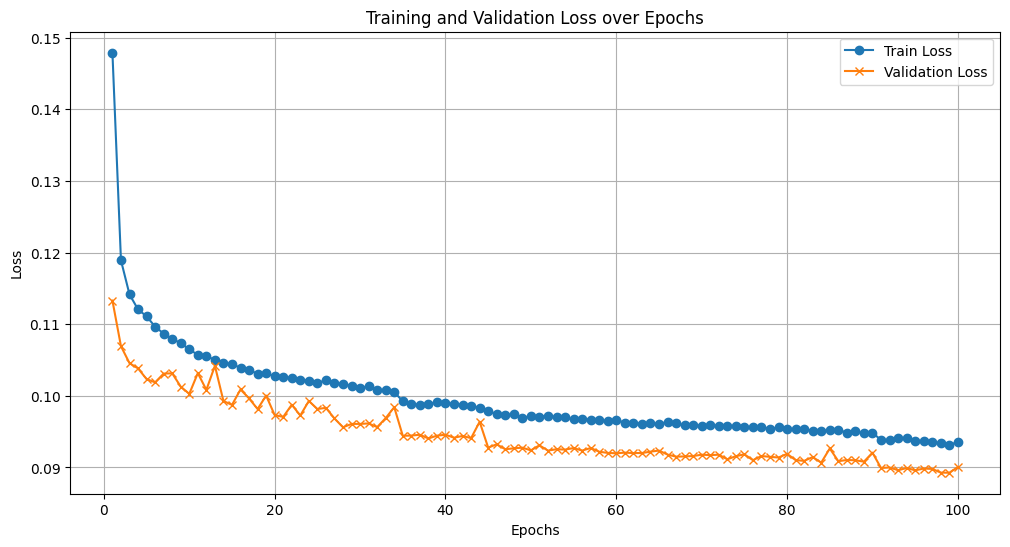

In [156]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='x')  # <-- Add validation losses here!
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [157]:
# 1. Reload your TabularResNet model architecture
model = TabularResNet(in_features=21).to(device)  # <-- Make sure input size matches
model.load_state_dict(torch.load('nn_model1_weights/best_tabular_resnet.pth'))  # Load best weights
model.eval()  # Important: set to evaluation mode

# 2. Testing Loop
test_losses = []
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        inputs_batch, outputs_batch = batch
        inputs_re = inputs_batch.to(device)
        outputs_re = outputs_batch.to(device).reshape(-1, 1)  # normalized resale prices

        # 3. Forward pass
        test_pred = model(inputs_re)

        # 4. Compute loss (still in normalized space)
        loss = nn.SmoothL1Loss()(test_pred.float(), outputs_re.float())
        test_losses.append(loss.item())

        # 5. Save preds and targets
        all_preds.append(test_pred.cpu())
        all_targets.append(outputs_re.cpu())

# 6. Calculate average test loss (normalized)
avg_test_loss = sum(test_losses) / len(test_losses)
print(f'Test Loss (normalized): {avg_test_loss:.4f}')

# 7. Load scalers (for de-normalization)
feature_scaler = joblib.load('scalers/feature_scaler.pkl')
target_scaler = joblib.load('scalers/target_scaler.pkl')

# 8. De-normalize predictions and targets
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

all_preds_real = target_scaler.inverse_transform(all_preds)
all_targets_real = target_scaler.inverse_transform(all_targets)

# 9. Evaluate real-world metrics (e.g., MAE)
real_loss = np.mean(np.abs(all_preds_real - all_targets_real))
print(f'Test Mean Absolute Error (SGD): {real_loss:,.2f}')


Test Loss (normalized): 0.0914
Test Mean Absolute Error (SGD): 51,394.57
